<a href="https://colab.research.google.com/github/FiorenSt/SiSAD/blob/main/Tutorial_StampAD_LATENT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#STAMP AD Project - LATENT SPACE

## The goal is to build a network for unsupervised (or semi-supervised) clustering and detection of anomalies and transients in ZTF stamps.
### Here, we assume a network has already been trained and we want to evaluate its latent space predictions...

## To get started:

Step 0.
Click the link to access the google drive folder containing the images: [link Drive](https://drive.google.com/drive/folders/1nnenrg4EnyxGy9WsAofwOOBRjlYfO_Ex?usp=sharing)

Step 1.
Right click on the folder. Under Organize, click Add Shortcut (Add it to your drive)

Step 2.
Mount your drive in Colab with the code below

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
h5_folder_path = '/content/drive/MyDrive/DATA_STAMP_AD'

In [5]:
import os

# Ensure the path is correct
assert os.path.exists(h5_folder_path), "The specified path does not exist. Please check the path to the shared folder."

# List the first few files in the directory
print("Contents of the folder:", os.listdir(h5_folder_path)[:5])

Contents of the folder: ['data_371.h5', 'data_372.h5', 'data_373.h5', 'data_374.h5', 'data_375.h5']


## Files description

Each h5 file contains 1024 triplets (new, reference, difference) and a list of features associated to these triplets. (rb_score, drb_score, fid, magpsf, sigmapsf, classtar, ra, dec, fwhm, aimage, bimage, elong, nbad, nneg, jd, ndethist, ncovhist, jdstarthist, jdendhist) To visualize some of the images, run the code below:

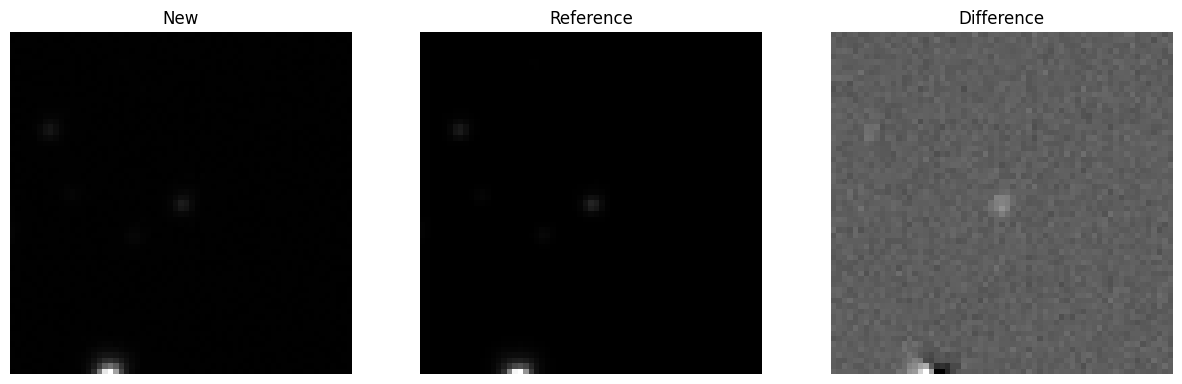

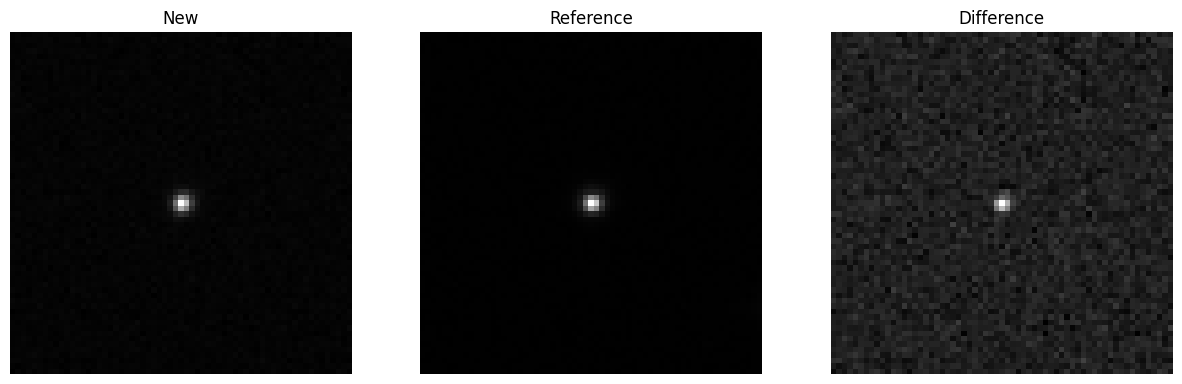

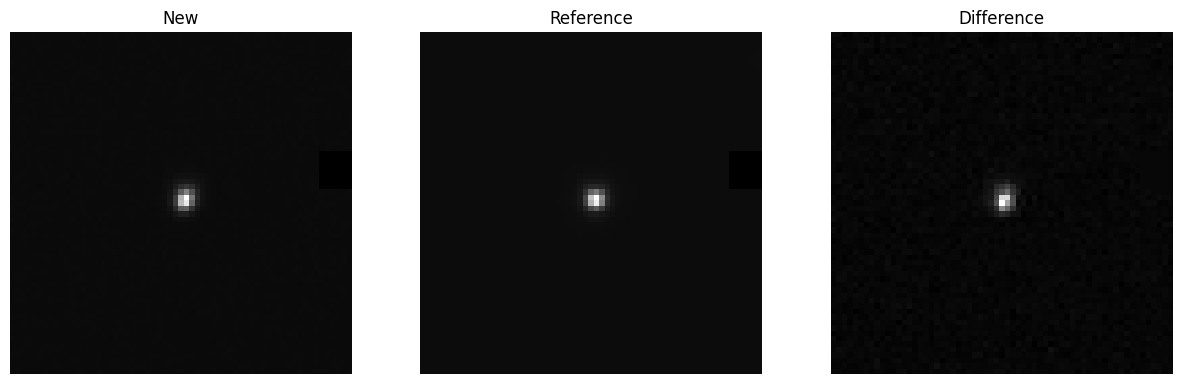

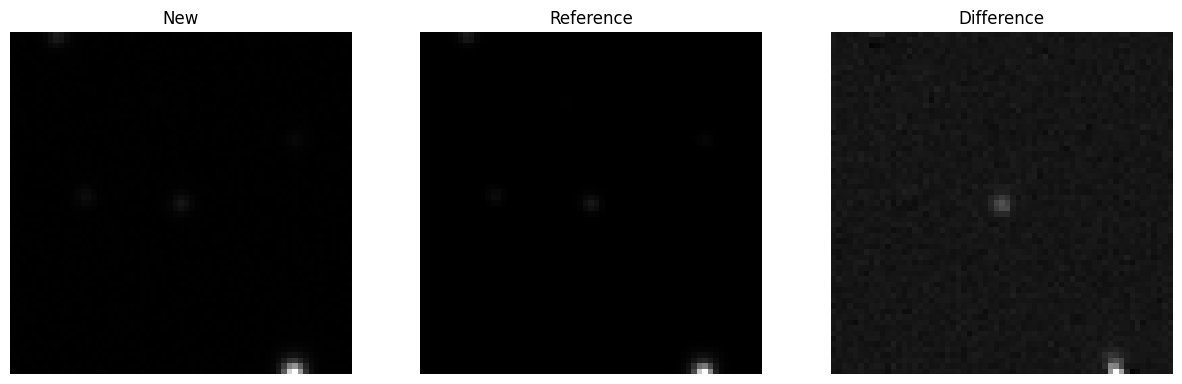

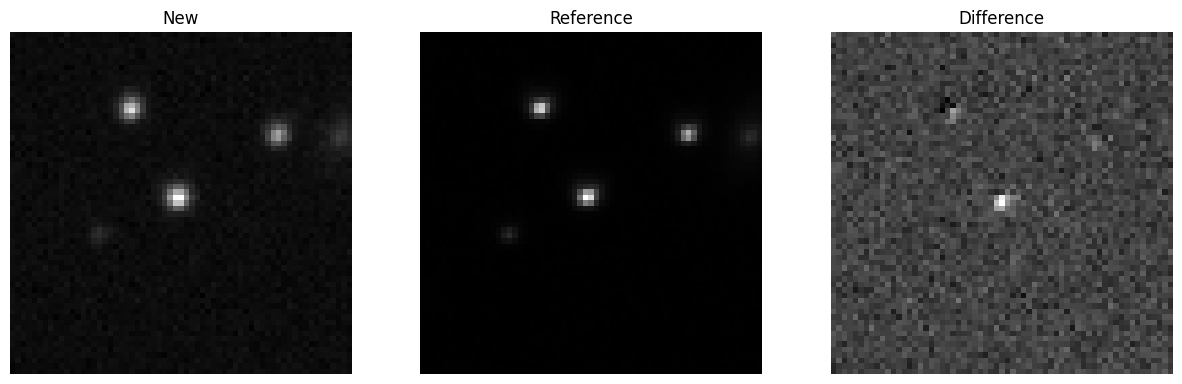

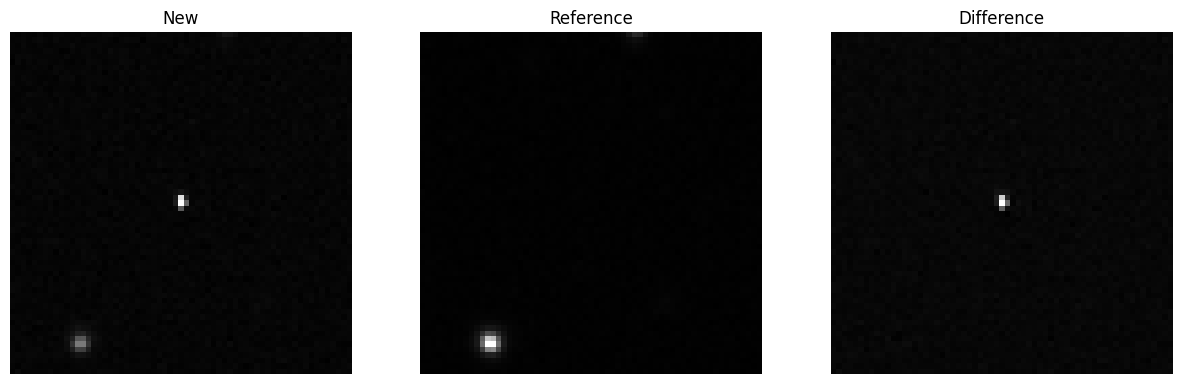

In [4]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
from pathlib import Path

# Function to plot a single triplet
def plot_triplet(triplet):
    """Plot a triplet of images."""
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    titles = ['New', 'Reference', 'Difference']
    for i, img in enumerate(triplet):
        axs[i].imshow(img, cmap='gray', origin='lower')
        axs[i].title.set_text(titles[i])
        axs[i].axis('off')
    plt.show()

# Example usage
all_image_paths = [str(path) for path in Path(h5_folder_path).glob('*.h5')]

# Choose a subset of files for demonstration
sample_paths = all_image_paths[:6]  # Adjust as needed

for file_path in sample_paths:
    with h5py.File(file_path, 'r') as hf:
        images = hf['images'][:]  # Assuming 'images' dataset shape is (N, 3, height, width)

        # Select and plot the first triplet from each file for demonstration
        img1, img2, diff_img = images[0]  # Extract the first triplet
        img1_nan_to_num = np.nan_to_num(img1, nan=0.0)
        img2_nan_to_num = np.nan_to_num(img2, nan=0.0)
        diff_img_nan_to_num = np.nan_to_num(diff_img, nan=0.0)

        plot_triplet([img1_nan_to_num, img2_nan_to_num, diff_img_nan_to_num])


# Example of preprocessing and simple network with Tensorflow

In [18]:
from skimage.exposure import rescale_intensity
import numpy as np
import h5py

def crop_center(img, cropx, cropy):
    """Crop the image in the center to the specified size."""
    y, x = img.shape  # Adjusted to expect 2D images
    startx = x // 2 - (cropx // 2)
    starty = y // 2 - (cropy // 2)
    return img[starty:starty + cropy, startx:startx + cropx]


def normalize_images(img1, img2):
    """Normalize first and second images together."""
    combined = np.stack([img1, img2])  # Combine images
    p2, p98 = np.percentile(combined, (2, 98))
    img1_rescaled = rescale_intensity(img1, in_range=(p2, p98))
    img2_rescaled = rescale_intensity(img2, in_range=(p2, p98))
    return img1_rescaled, img2_rescaled


def normalize_difference_based_on_range(diff_image, img1, img2):
    """Normalize the third image based on the range of the difference of the first two."""
    difference = img1 - img2
    diff_p2, diff_p98 = np.percentile(difference, (2, 98))
    diff_image_rescaled = rescale_intensity(diff_image, in_range=(diff_p2, diff_p98), out_range=(-1, 1))
    return diff_image_rescaled


def image_generator(image_paths, batch_size):
    """Yield batches of preprocessed input images, their corresponding output images, and labels."""
    for file_path in image_paths:
        with h5py.File(file_path, 'r') as hf:
            images = hf['images'][:]
            labels = hf['features'][:]

        # Process each triplet and its label in the file
        for start_idx in range(0, images.shape[0], batch_size):
            end_idx = min(start_idx + batch_size, images.shape[0])
            batch_triplets = images[start_idx:end_idx]
            batch_labels = labels[start_idx:end_idx]

            batch_inputs = []
            batch_outputs = []
            for idx, triplet in enumerate(batch_triplets):
                img1, img2, diff_img = [np.nan_to_num(img, nan=0.0) for img in triplet]
                img1_normalized, img2_normalized = normalize_images(img1, img2)
                diff_img_normalized = normalize_difference_based_on_range(diff_img, img1, img2)

                img1_cropped = crop_center(img1_normalized, 48, 48).reshape(48, 48, 1)
                img2_cropped = crop_center(img2_normalized, 48, 48).reshape(48, 48, 1)
                diff_img_cropped = crop_center(diff_img_normalized, 48, 48).reshape(48, 48, 1)

                input_images = np.concatenate([img1_cropped, img2_cropped], axis=-1)
                output_image = diff_img_cropped
                batch_inputs.append(input_images)
                batch_outputs.append(output_image)

            yield np.array(batch_inputs), np.array(batch_outputs), batch_labels


def get_test_with_features(image_paths, batch_size=1024):
    dataset = tf.data.Dataset.from_generator(
        lambda: image_generator(image_paths, batch_size),
        output_types=(tf.float32, tf.float32, tf.float32),  # Assuming generator yields inputs, outputs, and features
        output_shapes=([None, 48, 48, 2], [None, 48, 48, 1], [None, 19])
    )
    return dataset.map(lambda x, y, z: (x, z))  # Return inputs and features, ignore outputs




In [32]:
from tensorflow.keras.models import load_model
from tensorflow.keras import Input, Model
from pathlib import Path
import tensorflow as tf

# Load the full U-Net model
model_path = '/content/drive/MyDrive/DATA_STAMP_AD/MODELS/best_model.h5'
full_model = load_model(model_path)

from tensorflow.keras.layers import GlobalAveragePooling2D

pre_bottleneck_output = full_model.get_layer('bottleneck').output

# Attach the GAP layer to this output
gap_output = GlobalAveragePooling2D(name='gap_bottleneck')(pre_bottleneck_output)

# This model takes the original inputs but outputs the result of the GAP layer
bottleneck_model = Model(inputs=full_model.input, outputs=gap_output)


all_image_paths = [str(path) for path in Path('/content/drive/MyDrive/DATA_STAMP_AD/').glob('*.h5')]
test_dataset_with_features = get_test_with_features(all_image_paths, batch_size=1024)

# Assuming full_model is your model for prediction
predictions_list = []
features_list = []
for inputs, features in test_dataset_with_features:
    batch_predictions = bottleneck_model.predict(inputs)
    predictions_list.extend(batch_predictions)
    features_list.extend(features.numpy())  # Convert tensor to numpy if needed

# Convert lists to NumPy arrays
predictions = np.array(predictions_list)
features = np.array(features_list)

# Optionally, erase the original lists to free up memory
del predictions_list
del features_list


32/32 [==============================] - 0s 5ms/step


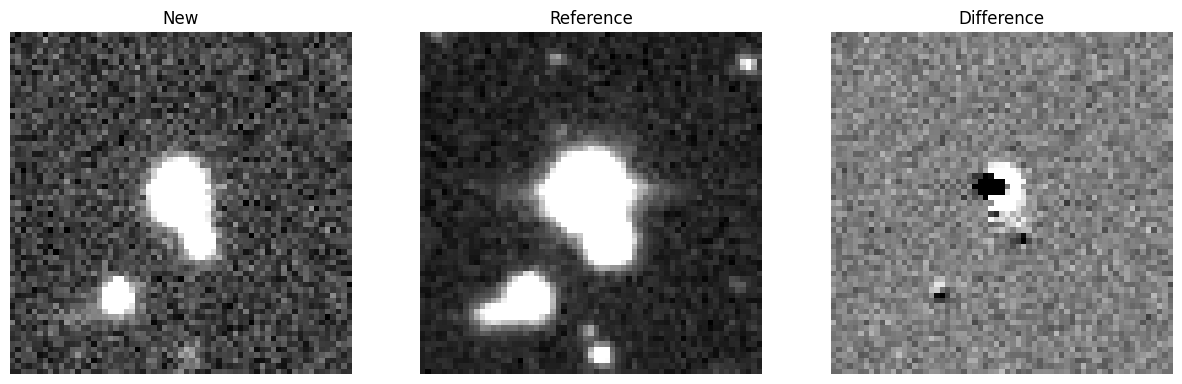

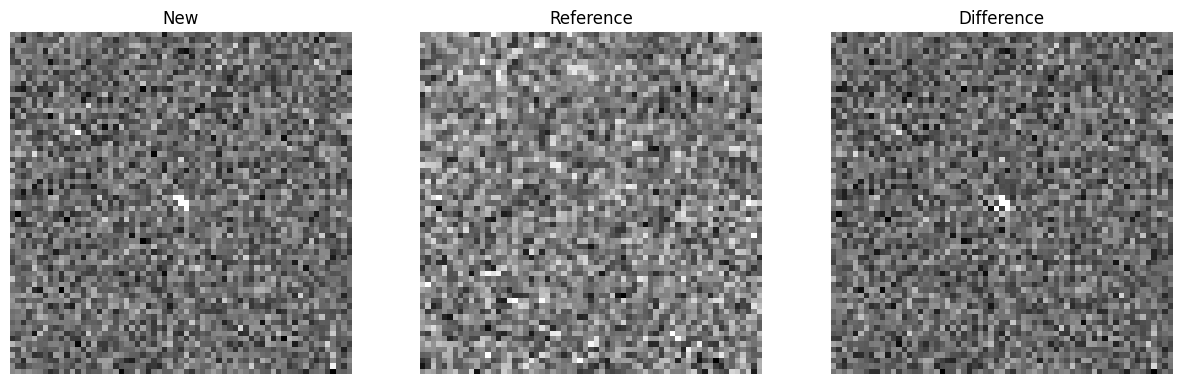

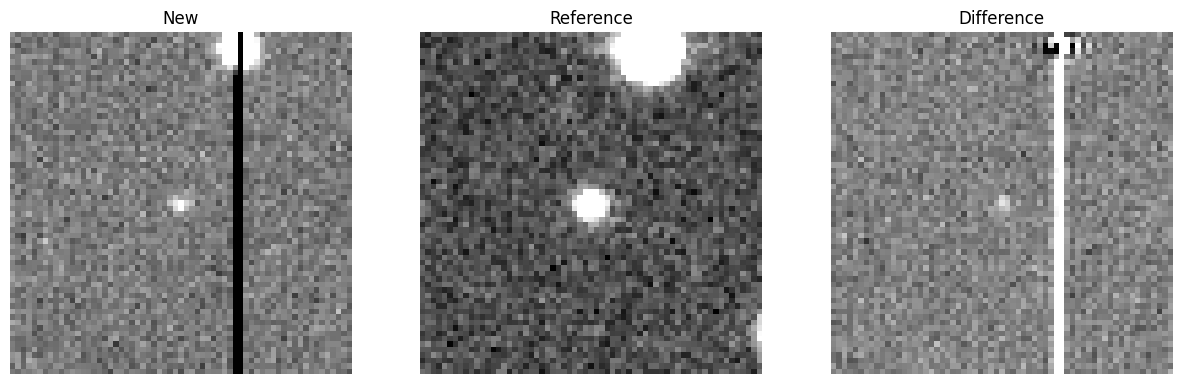

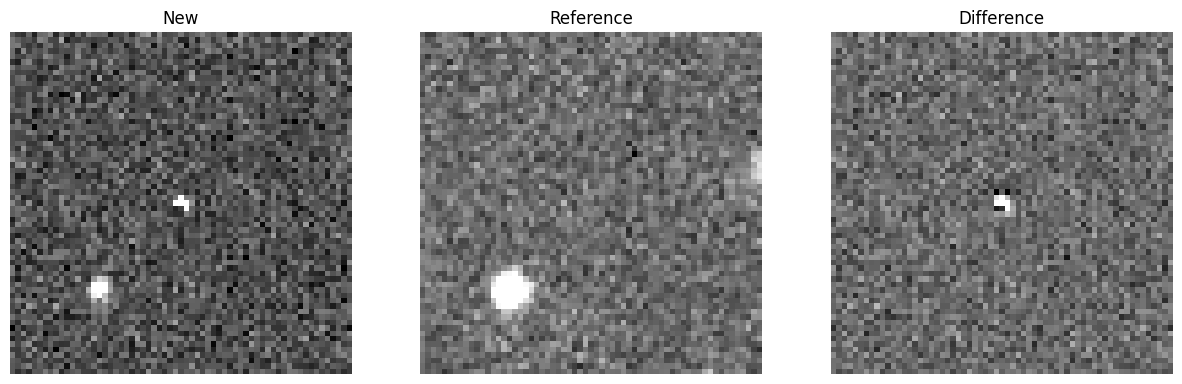

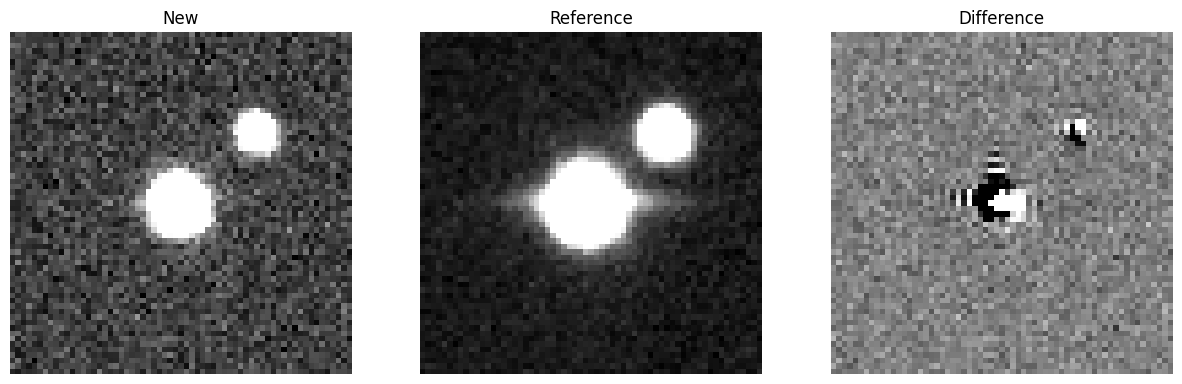

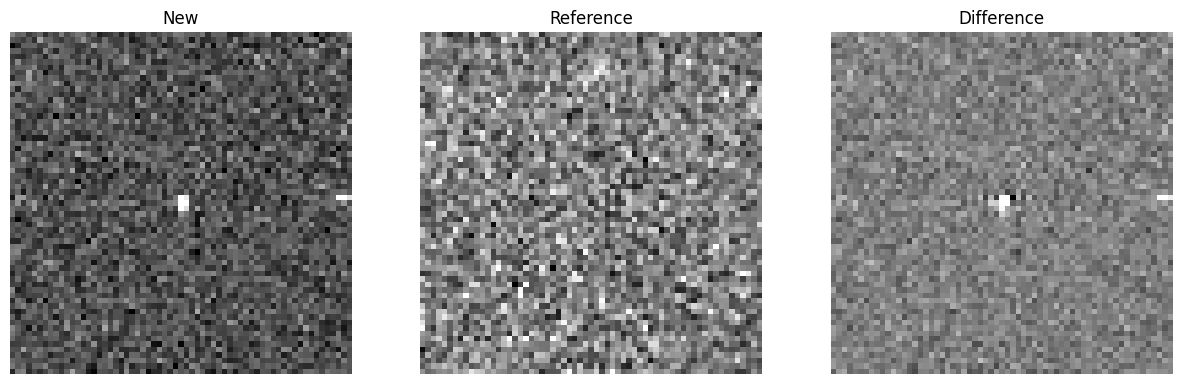

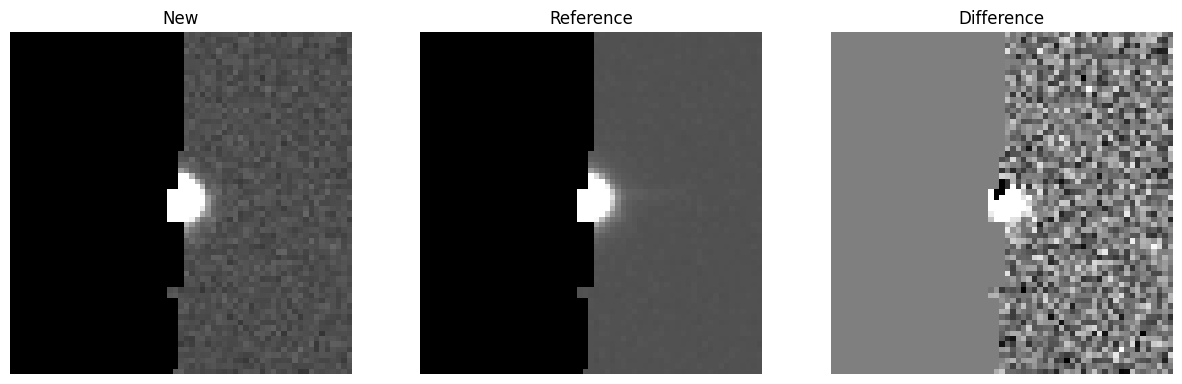

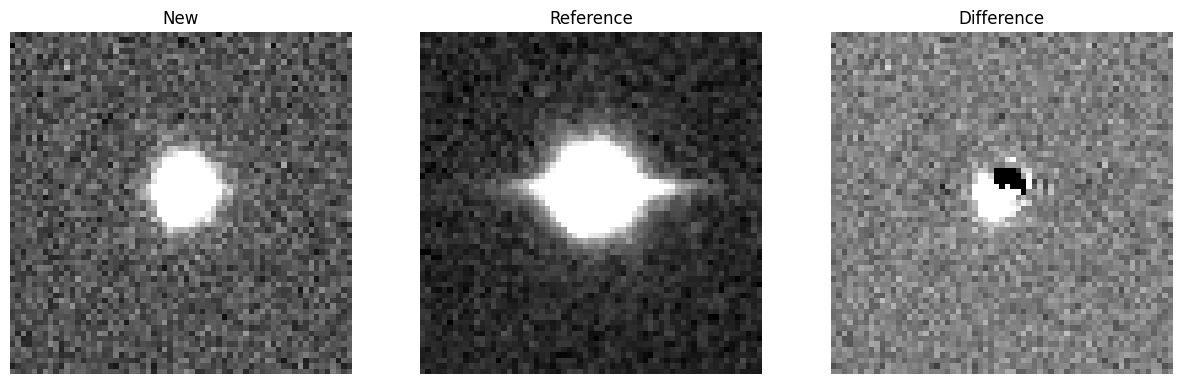

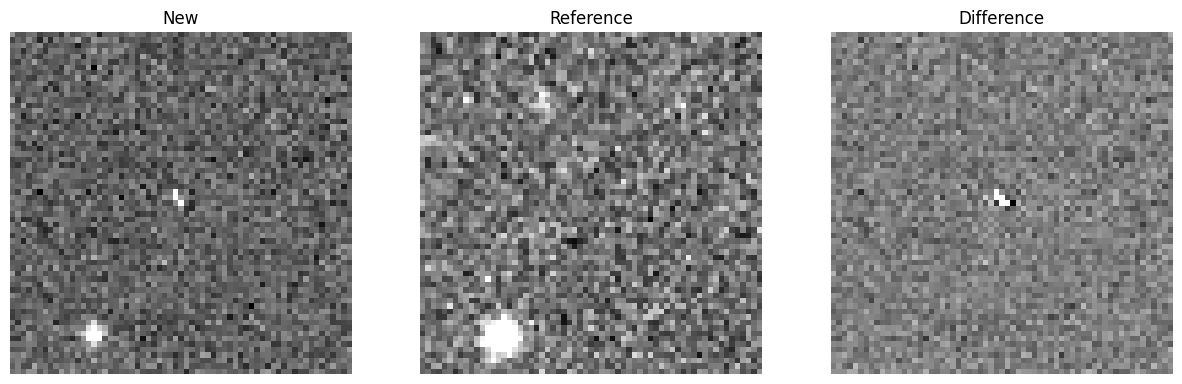

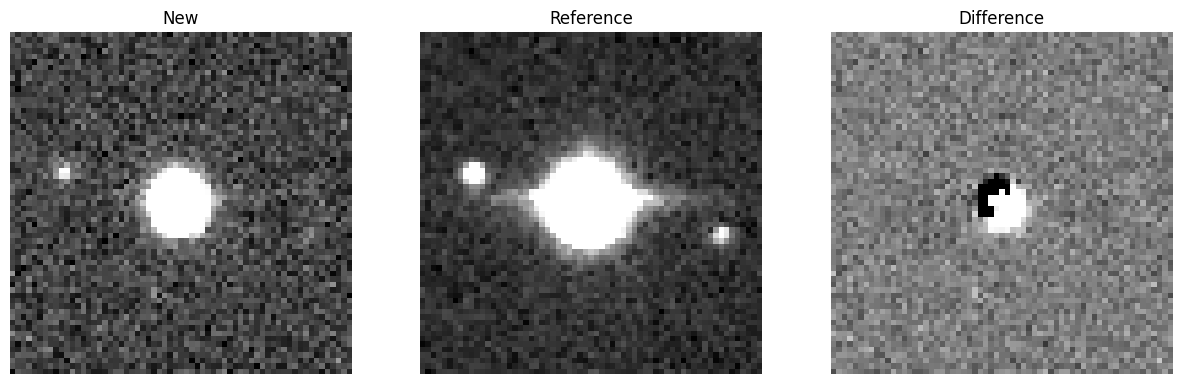

In [33]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from astropy.visualization import ZScaleInterval
import os

# Define the threshold for low DRB scores
DRB_THRESHOLD = 0.0001  # Adjust as necessary for "really low"

# Assume DRB score is at a specific index, e.g., index 0
drb_scores = features[:, 1]

# Identify indices of low DRB scores
low_drb_indices = np.where(drb_scores <= DRB_THRESHOLD)[0]


def plot_images_with_low_drb(low_drb_indices, image_paths, batch_size=1024, samples_to_plot=10):
    """
    Plots a subset of images associated with low DRB scores.
    """
    zscale = ZScaleInterval()

    plotted = 0

    for file_path in image_paths:
        with h5py.File(file_path, 'r') as hf:
            images = hf['images'][:]

        # Only proceed if the current file contains relevant images
        relevant_indices = [idx for idx in low_drb_indices if idx < images.shape[0]]
        if not relevant_indices:
            continue

        for idx in relevant_indices:
            if plotted >= samples_to_plot:
                break

            # Extract and preprocess images
            img1, img2, diff_img = images[idx]

            # Plot images
            fig, axs = plt.subplots(1, 3, figsize=(15, 5))
            for ax, img, title in zip(axs, [img1, img2, diff_img], ['New', 'Reference', 'Difference']):
                vmin, vmax = zscale.get_limits(img)
                ax.imshow(img, cmap='gray', vmin=vmin, vmax=vmax)
                ax.set_title(title)
                ax.axis('off')

            plt.show()
            plotted += 1


# Load and preprocess images from paths with low DRB scores
plot_images_with_low_drb(low_drb_indices, all_image_paths, samples_to_plot=10)


In [34]:
!pip install umap-learn

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Clustering completed. Cluster labels: [-1  0  1  2  3]


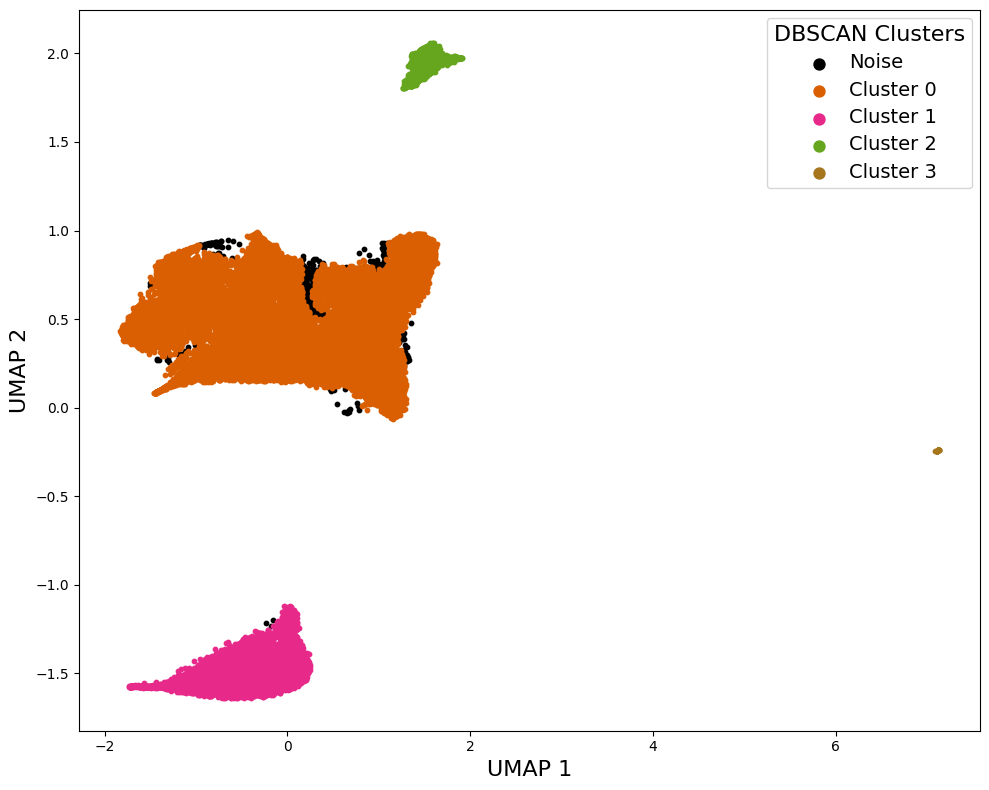

In [35]:
from sklearn.preprocessing import StandardScaler
import umap

# Standardize the features
scaler = StandardScaler()
latent_features_standardized = scaler.fit_transform(predictions)


# Apply UMAP on standardized featues
reducer = umap.UMAP(n_neighbors=500, min_dist=0, n_components=2, metric='manhattan', random_state=42)
latent_features_2d = reducer.fit_transform(latent_features_standardized)


from sklearn.cluster import DBSCAN

latent_features_standardized_2d = scaler.fit_transform(latent_features_2d)


# Apply DBSCAN on the extracted features
clustering = DBSCAN(eps=.068, min_samples=80)
cluster_labels = clustering.fit_predict(latent_features_standardized_2d)

print("Clustering completed. Cluster labels:", np.unique(cluster_labels))


import matplotlib.pyplot as plt

# Choose a more visually appealing colormap for categorical data
colormap = plt.get_cmap('Dark2')
num_unique_labels = len(np.unique(cluster_labels))

fig, ax = plt.subplots(figsize=(10, 8))

# Iterate through clusters and plot each cluster with a unique color from the "Set2" colormap
for i, label in enumerate(np.unique(cluster_labels)):
    color = colormap(i / num_unique_labels) if label != -1 else 'k'  # Keep 'Noise' points black

    points = latent_features_standardized_2d[cluster_labels == label]
    # Adjust marker size for visibility
    ax.scatter(points[:, 0], points[:, 1], s=10, color=color, label=f'Cluster {label}' if label != -1 else 'Noise')

# Customize plot
legend = ax.legend(title="DBSCAN Clusters", markerscale=2.5, title_fontsize='16', fontsize='12', loc='upper right')
plt.setp(legend.get_texts(), fontsize=14)  # Set legend text size
ax.set_xlabel('UMAP 1', fontsize=16)
ax.set_ylabel('UMAP 2', fontsize=16)
plt.tight_layout()
plt.show()


In [ ]:
import matplotlib.pyplot as plt
from astropy.visualization import ZScaleInterval
import numpy as np
import h5py

def plot_images_for_clusters_grid(image_paths, cluster_labels, samples_per_cluster=10, clusters_per_row=1):
    """
    Plots a grid of images for each cluster identified by UMAP and DBSCAN, with space between clusters.
    """
    zscale = ZScaleInterval()
    unique_labels = [label for label in np.unique(cluster_labels) if label != -1]  # Exclude noise

    # Ensure the figure is large enough to display all images clearly.
    total_clusters = len(unique_labels)
    fig_height_per_row = 5
    total_rows_needed = total_clusters * samples_per_cluster + total_clusters - 1  # Including spacing rows
    fig, axs = plt.subplots(total_rows_needed, clusters_per_row * 3, figsize=(15 * clusters_per_row, fig_height_per_row * total_rows_needed))

    if total_rows_needed == 1:  # Ensure axs is always 2D
        axs = np.array([axs])

    current_ax_index = 0

    for label in unique_labels:
        cluster_indices = np.where(cluster_labels == label)[0][:samples_per_cluster]

        # Add cluster label as a title for the first image of each cluster
        if clusters_per_row * 3 > 1:
            axs[current_ax_index, 0].set_title(f'Cluster {label}', fontsize=14, pad=20)
        else:
            axs[current_ax_index].set_title(f'Cluster {label}', fontsize=14, pad=20)

        for img_idx in cluster_indices:
            file_path = image_paths[img_idx // 1024]  # Assuming 1024 images per file
            img_in_file_index = img_idx % 1024

            with h5py.File(file_path, 'r') as hf:
                images = hf['images'][img_in_file_index]
                img1, img2, diff_img = images

            for i, img in enumerate([img1, img2, diff_img]):
                ax = axs[current_ax_index, i % (clusters_per_row * 3)] if total_rows_needed > 1 else axs[i % (clusters_per_row * 3)]
                vmin, vmax = zscale.get_limits(img)
                ax.imshow(img, cmap='gray', vmin=vmin, vmax=vmax)
                ax.axis('off')

            current_ax_index += 1  # Move to the next row for the next sample

        # Skip a row (add space) between clusters, but not after the last cluster
        if label != unique_labels[-1]:
            current_ax_index += 1

    plt.show()

# Assuming all_image_paths and cluster_labels are defined and available
plot_images_for_clusters_grid(all_image_paths, cluster_labels, samples_per_cluster=10, clusters_per_row=1)


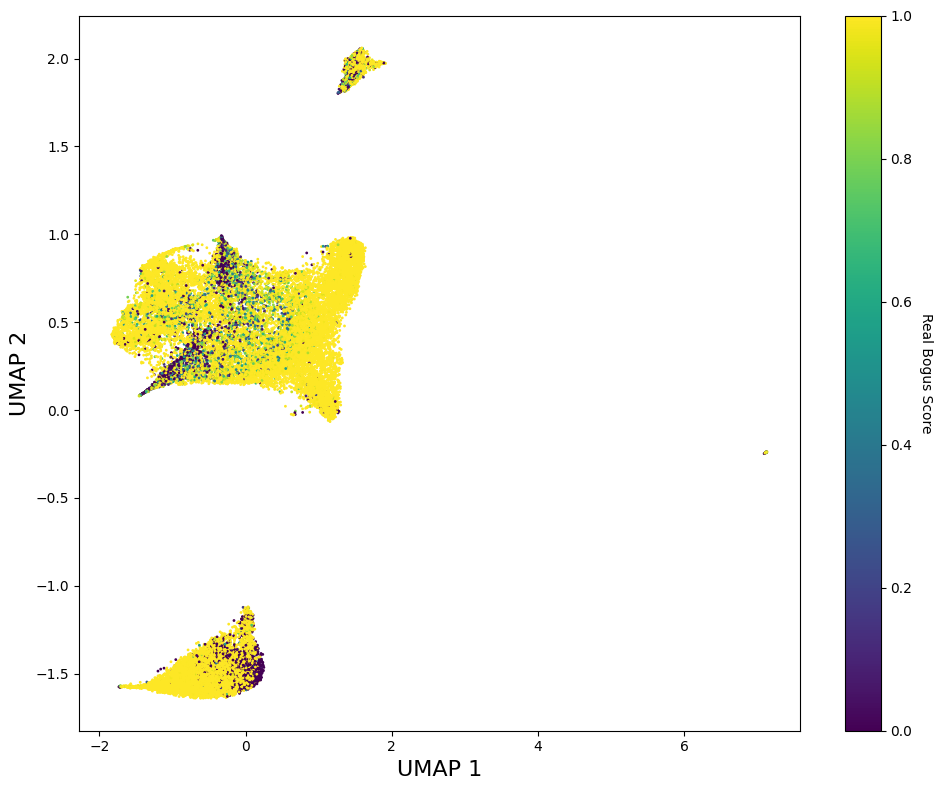

In [38]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming latent_features_standardized_2d is your data points for plotting
rb_scores = features[:,1]

# Normalize RB scores to [0, 1] for colormap mapping
rb_scores_normalized = rb_scores - np.min(rb_scores)
rb_scores_normalized /= np.max(rb_scores_normalized)

# Choose a continuous colormap
colormap = plt.get_cmap('viridis')

fig, ax = plt.subplots(figsize=(10, 8))

# Scatter plot colored by RB score
sc = ax.scatter(latent_features_standardized_2d[:, 0], latent_features_standardized_2d[:, 1],
                c=rb_scores_normalized, cmap=colormap, s=1)

# Add a colorbar to the plot
cbar = plt.colorbar(sc)
cbar.set_label('Real Bogus Score', rotation=270, labelpad=15)

ax.set_xlabel('UMAP 1', fontsize=16)
ax.set_ylabel('UMAP 2', fontsize=16)
plt.tight_layout()
plt.show()
